<a href="https://colab.research.google.com/github/3b032092/2025_ML_Hws/blob/main/hw5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#下載並解壓 IMDb 資料集

In [17]:
import os
import urllib.request
import tarfile

if not os.path.exists('data'):
    os.makedirs('data')

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filepath = "data/aclImdb_v1.tar.gz"
if not os.path.isfile(filepath):
    urllib.request.urlretrieve(url, filepath)
    print('Downloaded:', filepath)

if not os.path.exists("data/aclImdb"):
    with tarfile.open(filepath, 'r:gz') as tfile:
        tfile.extractall('data/')
    print('Extracted to:', 'data/aclImdb')

#檢視資料夾結構

In [18]:
import os

base_dir = 'data/aclImdb'
print("Train directories:", os.listdir(os.path.join(base_dir, 'train')))
print("Test directories:", os.listdir(os.path.join(base_dir, 'test')))

Train directories: ['pos', 'unsup', 'neg', 'labeledBow.feat', 'urls_neg.txt', 'unsupBow.feat', 'urls_pos.txt', 'urls_unsup.txt']
Test directories: ['pos', 'neg', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt']


#定義 函數

In [20]:
import re

def rm_tags(text):
    """移除 HTML 標籤"""
    return re.sub(r'<[^>]+>', '', text)

import os

def read_files(filetype):
    """讀取指定類型的影評"""
    path = os.path.join(base_dir, 'train', filetype)
    file_list = [os.path.join(path, f) for f in os.listdir(path)]
    all_labels = [1] * len(file_list) if filetype == 'pos' else [0] * len(file_list)
    all_texts = [rm_tags(open(f, encoding='utf-8').read()) for f in file_list]
    return all_labels, all_texts

#建立訓練與測試資料

In [21]:
y_train_pos, train_text_pos = read_files('pos')
y_train_neg, train_text_neg = read_files('neg')
y_train = y_train_pos + y_train_neg
train_text = train_text_pos + train_text_neg

y_test_pos, test_text_pos = read_files('pos')
y_test_neg, test_text_neg = read_files('neg')
y_test = y_test_pos + y_test_neg
test_text = test_text_pos + test_text_neg

# 建立 Tokenizer 並轉換影評為數字串

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_text)

x_train = tokenizer.texts_to_sequences(train_text)
x_test = tokenizer.texts_to_sequences(test_text)

maxlen = 500
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

#建立神經網路模型

In [23]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Embedding(10000, 128, input_length=maxlen))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#訓練模型並切分驗證資料

In [24]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 424ms/step - accuracy: 0.5147 - loss: 0.6922 - val_accuracy: 0.5118 - val_loss: 0.6853
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 412ms/step - accuracy: 0.5910 - loss: 0.6691 - val_accuracy: 0.7320 - val_loss: 0.5902
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 432ms/step - accuracy: 0.7143 - loss: 0.5764 - val_accuracy: 0.7528 - val_loss: 0.5091
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 408ms/step - accuracy: 0.7920 - loss: 0.4818 - val_accuracy: 0.7338 - val_loss: 0.4813
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 414ms/step - accuracy: 0.8005 - loss: 0.4309 - val_accuracy: 0.5920 - val_loss: 1.0513
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 431ms/step - accuracy: 0.7467 - loss: 0.5350 - val_accuracy: 0.7542 - val_loss: 0.4558
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 488ms/step - accuracy: 0.8154 - loss: 0.3895 - val_accuracy: 0.7290 - val_loss: 0.5176
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 502ms/step - accuracy: 0.7965 - loss: 0.4149 - val_accu

#顯示訓練過程的 Loss 和 Accuracy

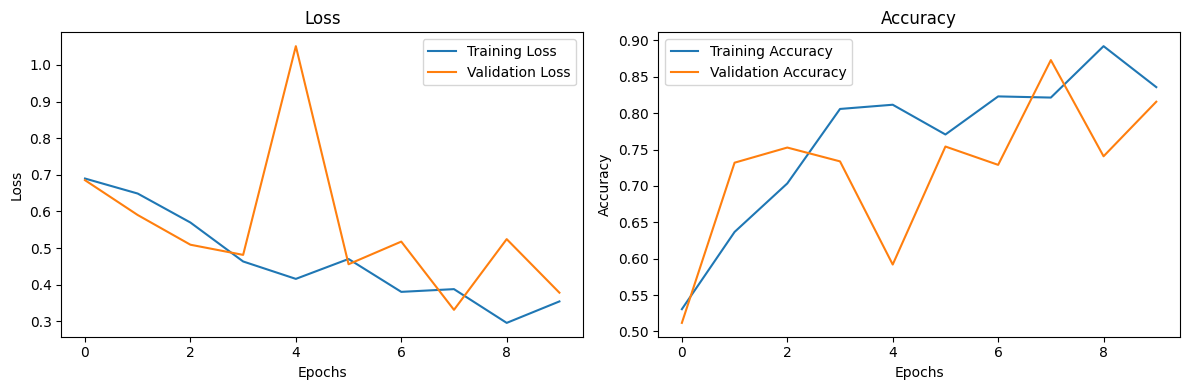

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#評估模型準確率

In [27]:
!python --version


Python 3.11.12


In [28]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Accuracy: %.4f" % test_acc)


782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7453 - loss: 0.4885
Test Accuracy: 0.8370
